# Spatial Model


Authoritarians and non-authoritarians thus differ in their perceived ideological proximity to the two parties. By extension, we might observe that ideological proximity has a different effect on voting for authoritarians. The basic argument is that if a particular candidate or party advances policy that maximizes a voter’s utility through policy, the voter should prefer and subsequently vote for that candidate or party (relative to the alternative; Jessee  2012).

It seems that ideological proximity can be defined in different ways -- it confuses me -- but this what I did in the analysis I circulated. Here's the model

``` 
# differenceR <- ideology - data$ideologyCR
# differenceD <- ideology - data$ideologyCD

spatial_dat <- filteredData %>%
  select(vote, differenceD, differenceR, authoritarianism, authoritarianism2, female, age, college, income, jewish, catholic, other, year) %>%
  na.omit() %>%
  mutate(diffCR = differenceR * differenceR) %>%
  mutate(diffCD = differenceD * differenceD) %>%
  mutate(diffOfdiff = diffCD - diffCR)


spatialModel <- brm(vote ~ authoritarianism + authoritarianism2 + diffOfdiff +
           authoritarianism * diffOfdiff + authoritarianism2 * diffOfdiff +
           female + age + college + income + jewish + catholic + other +
           (1 + authoritarianism + authoritarianism2 + diffOfdiff +
            authoritarianism * diffOfdiff + authoritarianism2 * diffOfdiff | year),
      family = bernoulli(link = "probit"),
      data = spatial_dat,
      chains = 3,
      cores = 8,
      seed = 1234,
      iter = 2000,
      control = list(adapt_delta = 0.9)
)
```

It's just a probit. *diffOdfdif* is the differences in ideological distances (squared) to the party candidate

$$
\mathrm{diffOfdiff} = (x_i - X_{Democrat})^2 - (x_i - X_{Republican})^2
$$

I interacted the variable with authoritarianism and authoritarianism-squared. And these effects vary across ANES cross section. So a score of zero would mean that the person is equidistant to both parties, and should be indifferent. A positive score means indicates the person is closer to the Republican candidate. A negative score means the person is closer to the Democratic candidate.

Here is what I wrote up before...shortened a bit.

 If one votes for the most proximal candidate -- then one that yields the most utility (U) -- then it follows that a voter will cast a Republican vote if the utility gained from the Republican candidate is higher than what would be obtained from the Democratic candidate. It's common to define utility in terms of ideological proximity -- which candidate most represents one's policy views and are thus likely to maximize one's utility. We might anticipate that utility is higher when the candidate's ideology is close. We calculate the squared ideological proximity to both candidates, $-(x_i - X_R)^2$ and $-(x_i - X_D)^2$, where $x_i$ corresponds to the respondent's ideology, and $X_D$ and $X_R$ represent the perceived ideology of the Democratic and Republican presidential candidates, respectively. Sometimes these values are just fixed at the sample means, but as we've already shown, perceptions of parties varies quite a bit. 
 
 So if this is the utility model

\begin{align*}
\mathrm{Vote \; Republican} =& pr(U(R_i) > U(D_i))\\
 \end{align*}

The person votes Republican when the utility of voting Republican is greater than the utility of voting Democratic -- i.e., the voter is ideologically closer to the Republican candidate. The stochastic version of this just means that the utility of voting Republican is greater than the utility of voting Democratic plus some error term.

\begin{align*}
pr(\mathrm{Vote \; Republican}) =& pr[(U(R_i) > U(D_i)]=\\
 =& pr[-a(x_i - X_R)^2  +  e_{i,R} > -a(x_i - X_D)^2  + e_{i,D}]\\
 =& pr[-a(x_i - X_R)^2 + a(x_i - X_D)^2    >   e_{i,D} - e_{i,R}]\\
 =& \Phi(-a(x_i - X_R)^2  + a(x_i - X_D)^2)\\
 \end{align*}


\begin{align*}
pr(\mathrm{Vote \; Republican}) =& pr[(U(R_i) > U(D_i)]=\\
 =& \Phi(b*[(x_i - X_R)^2  + (x_i - X_D)^2]+a))\\
 \end{align*}

 The thing on the right goes away because it's just a difference in error terms. This can be expressed as a probit regression -- regress the  voting on the distance variable (the ideal point). The intercept corresponds to the bias parameter -- it should be zero because when the difference variable is 0 that means the person reports being equidistant from both parties. On the other hand, the slope corresponds to precision. It's a weight corresponding to how aligned proximity is with voting. I plot everything below. I basically just change values for a and b to show how they change the interpretation.



In [ ]:
!export PATH=/Library/TeX/texbin:$PATH


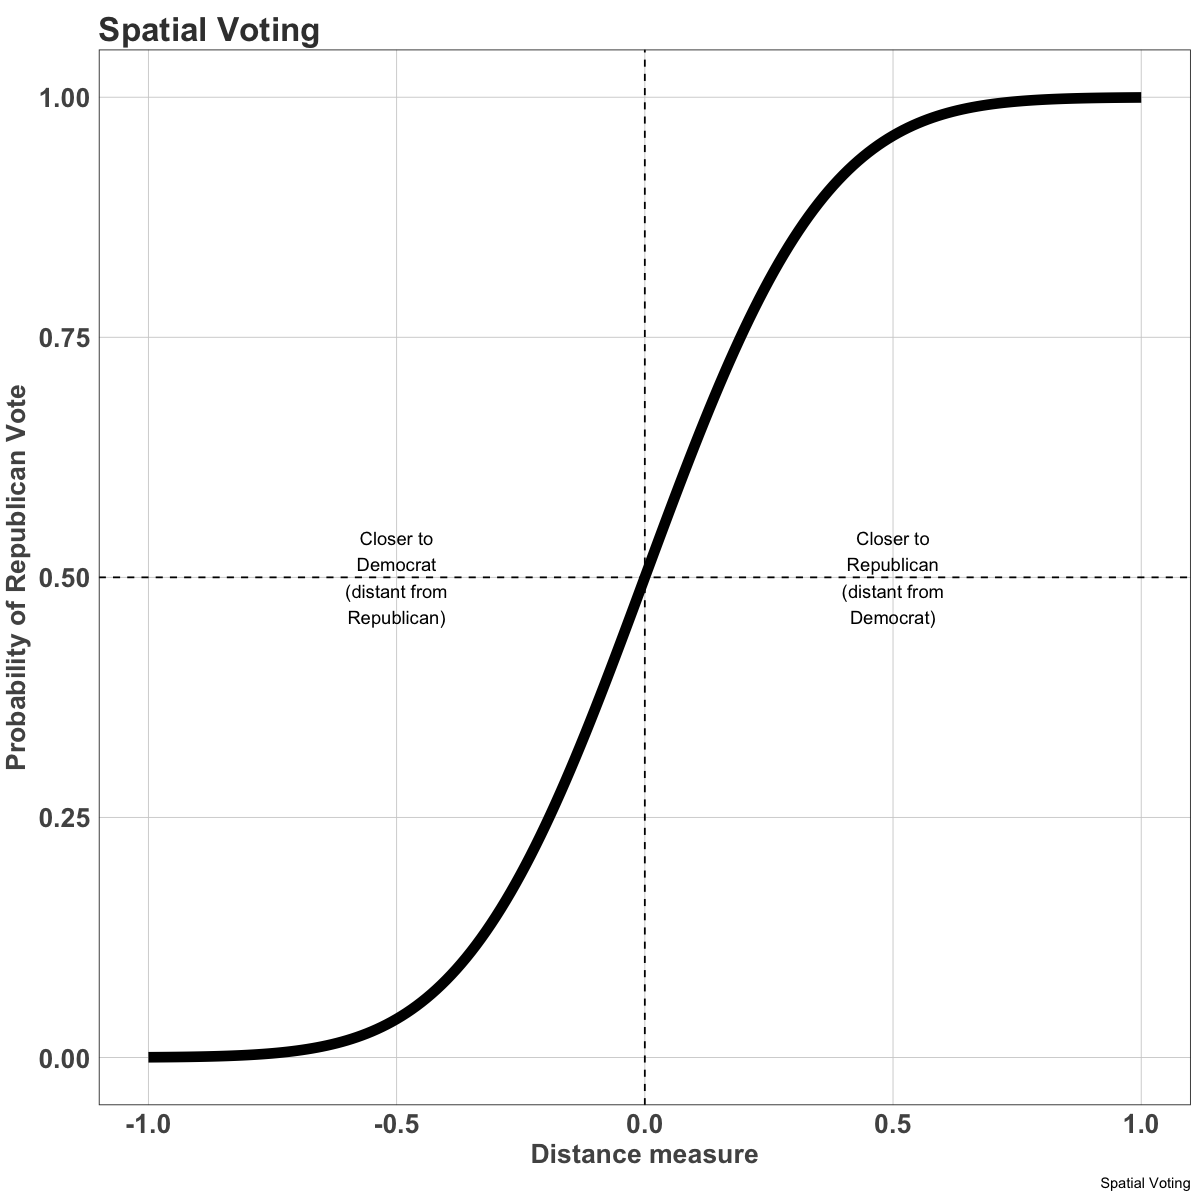

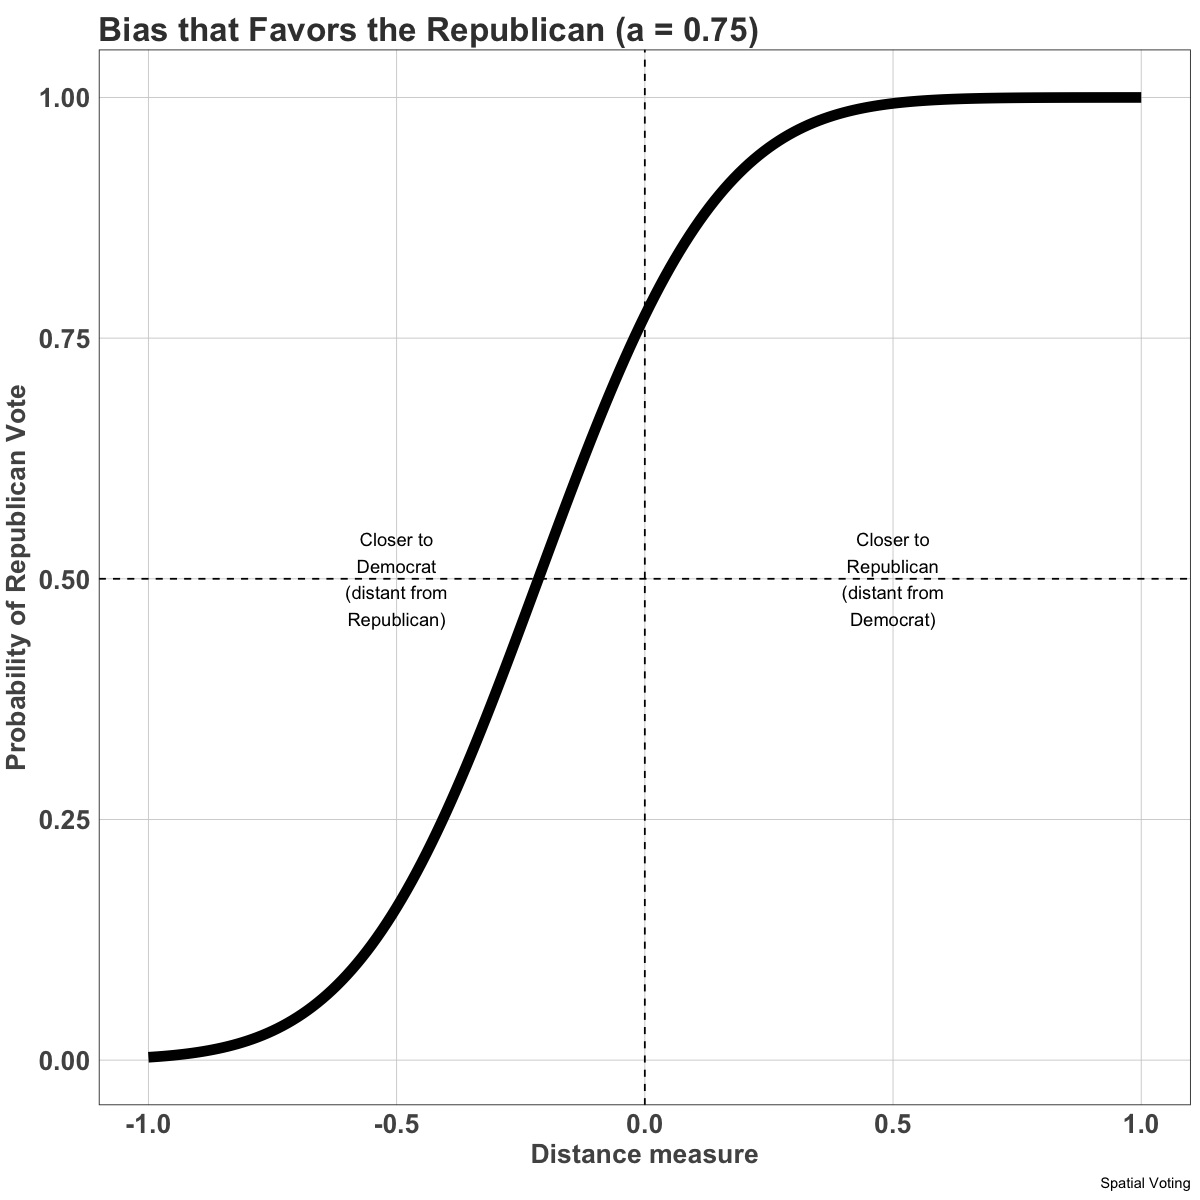

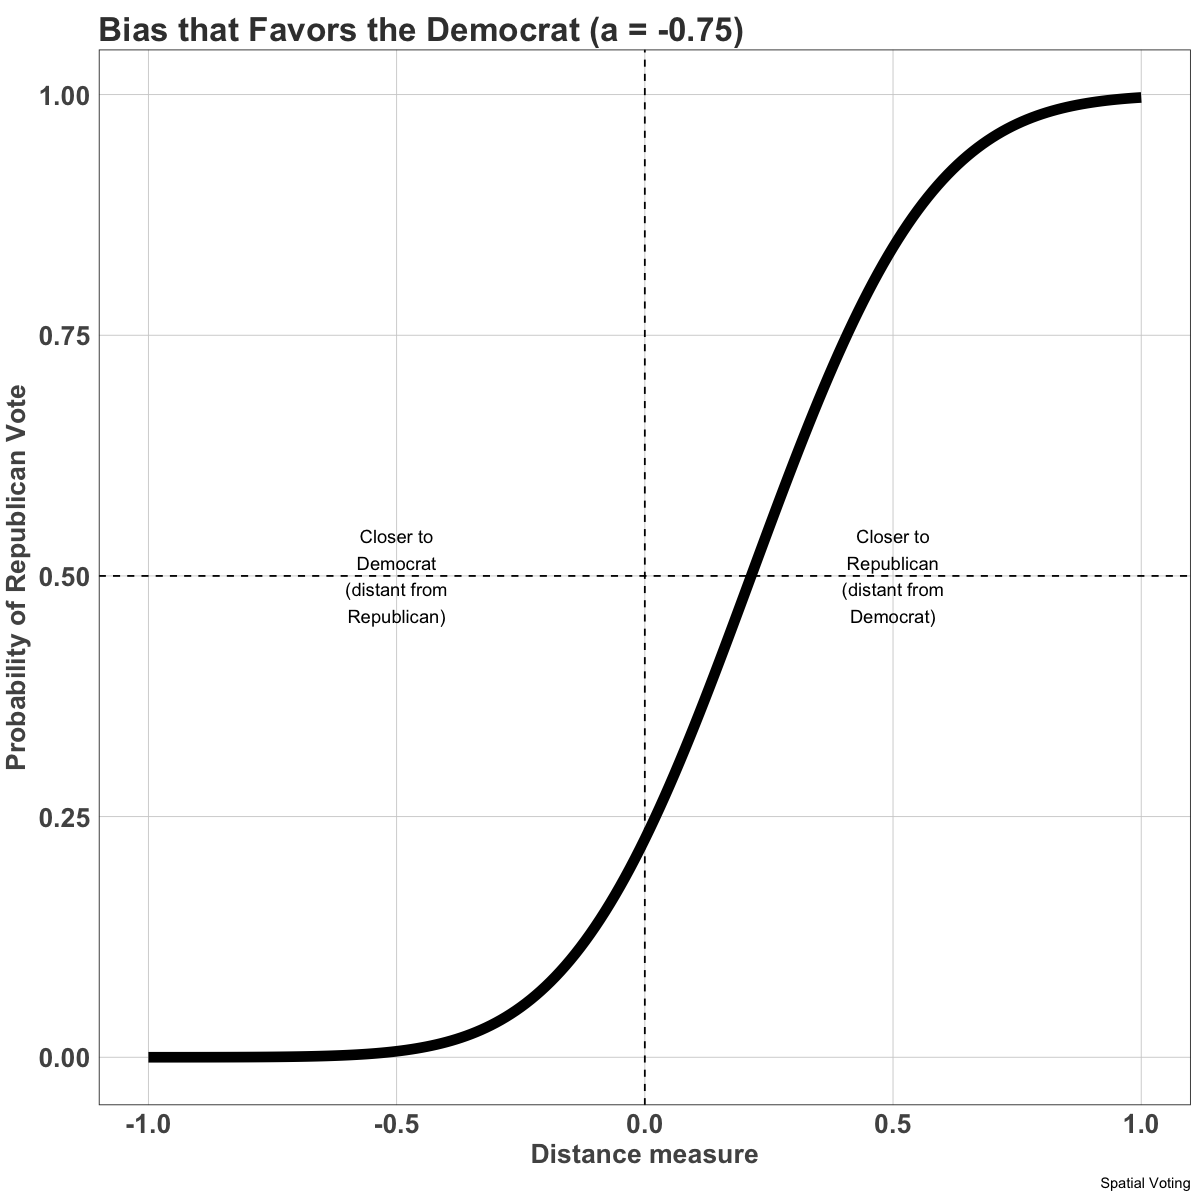

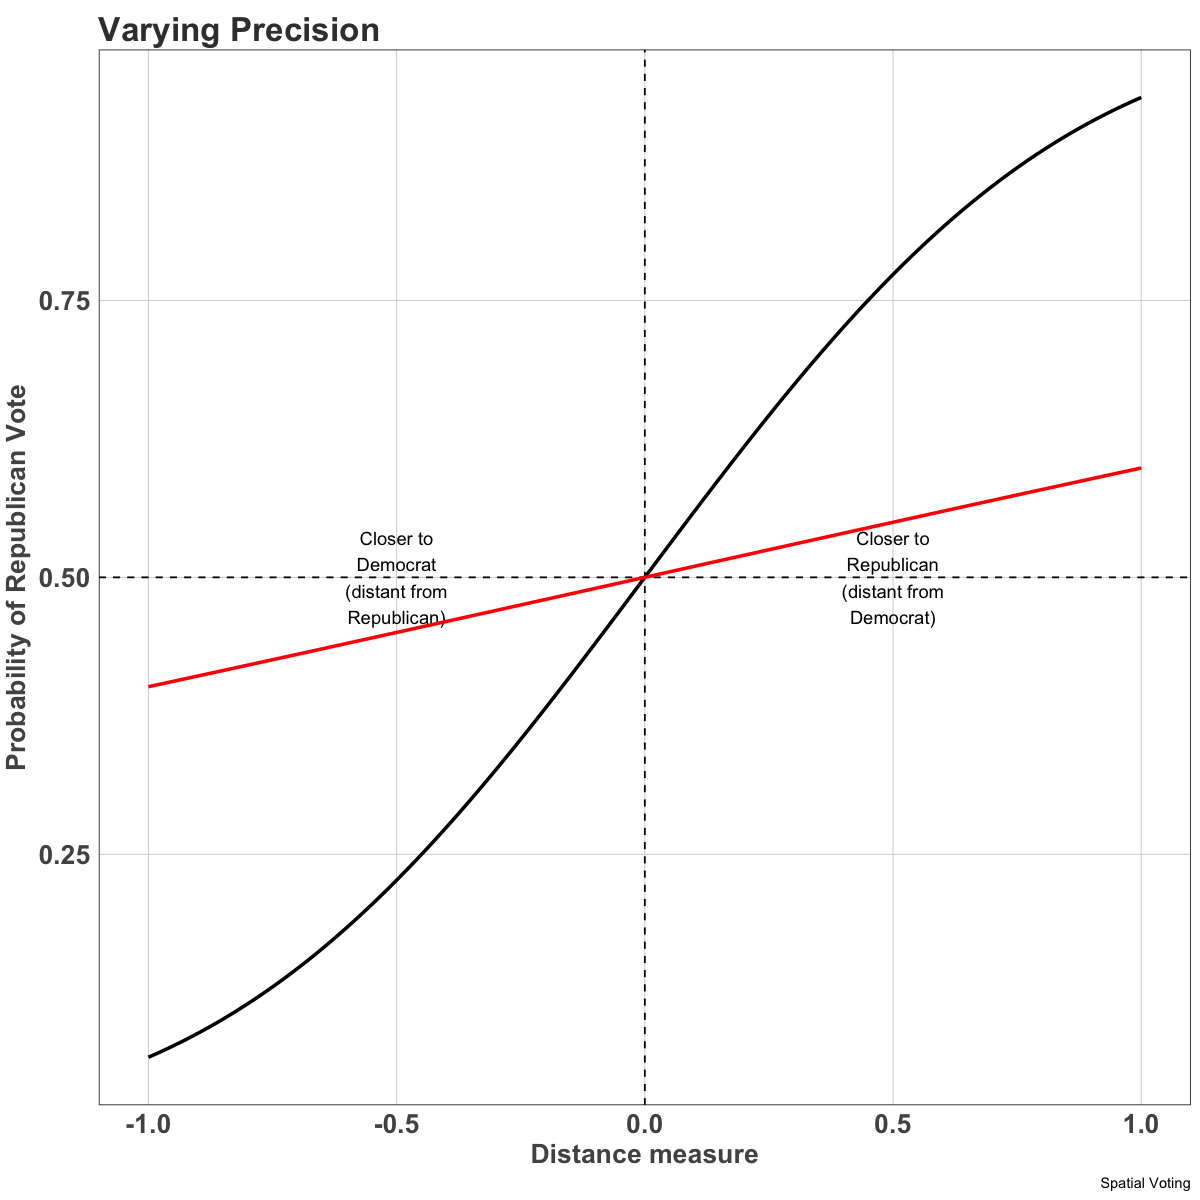

In [189]:
a = 0
b = 3.5
x = seq(-1, 1, 0.01)
y = pnorm(a + b * x)

ggplot(data = data.frame(x = x, y = y), aes(x = x, y = y)) +
  geom_line(size = 3) +
  ylab("") +
  geom_vline(xintercept = 0, linetype = "dashed") +

  annotate("text", x = -0.5, y = 0.5, label = "Closer to\nDemocrat\n(distant from\nRepublican)", colour = "black") +
  annotate("text", x = 0.5, y = 0.5, label = "Closer to\nRepublican\n(distant from\nDemocrat)", colour = "black") +
  scale_y_continuous("Probability of Republican Vote") +
  scale_x_continuous("Distance measure") +
  ggtitle("Spatial Voting") +
  theme_bw() +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  ) +
  ggtheme +
  labs(caption = "Spatial Voting") +
    geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed")

#####
a <- 0.75
b <- 3.5
x <- seq(-1, 1, 0.01)
y <- pnorm(a + b * x)
###33
ggplot(data = data.frame(x = x, y = y), aes(x = x, y = y)) +
  geom_line(size = 3) +
  ylab("") +
  geom_vline(xintercept = 0, linetype = "dashed") +
  annotate("text", x = -0.5, y = 0.5, label = "Closer to\nDemocrat\n(distant from\nRepublican)", colour = "black") +
  annotate("text", x = 0.5, y = 0.5, label = "Closer to\nRepublican\n(distant from\nDemocrat)", colour = "black") +
  scale_y_continuous("Probability of Republican Vote") +
  scale_x_continuous("Distance measure") +
  ggtitle("Bias that Favors the Republican (a = 0.75)") +
  theme_bw() +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  ) +
  ggtheme +
  labs(caption = "Spatial Voting") +
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") +
  geom_ribbon(aes(x = 0, ymin = 0.5, ymax = y), fill = "red", alpha = 0.2)

#####
a <- -0.75
b <- 3.5
x <- seq(-1, 1, 0.01)
y <- pnorm(a + b * x)
#####

ggplot(data = data.frame(x = x, y = y), aes(x = x, y = y)) +
  geom_line(size = 3) +
  ylab("") +
  geom_vline(xintercept = 0, linetype = "dashed") +
  annotate("text", x = -0.5, y = 0.5, label = "Closer to\nDemocrat\n(distant from\nRepublican)", colour = "black") +
  annotate("text", x = 0.5, y = 0.5, label = "Closer to\nRepublican\n(distant from\nDemocrat)", colour = "black") +
  scale_y_continuous("Probability of Republican Vote") +
  scale_x_continuous("Distance measure") +
  ggtitle("Bias that Favors the Democrat (a = -0.75)") +
  theme_bw() +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  ) +
  ggtheme +
  labs(caption = "Spatial Voting") +
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed")
   #Shade under the curve and greater than 0.5 and less than x less than 0


a <- 0
b1 <- 1.5
b2 <- 0.25
x <- seq(-1, 1, 0.01)
y1 <- pnorm(a + b1 * x)
y2 <- pnorm(a + b2 * x)

ggplot(data = data.frame(x = x, y = y1, y2 = y2), aes(x = x, y = y)) +
  geom_line(size = 1) +
  ylab("") +
  geom_vline(xintercept = 0, linetype = "dashed") +
  annotate("text", x = -0.5, y = 0.5, label = "Closer to\nDemocrat\n(distant from\nRepublican)", colour = "black") +
  annotate("text", x = 0.5, y = 0.5, label = "Closer to\nRepublican\n(distant from\nDemocrat)", colour = "black") +
  scale_y_continuous("Probability of Republican Vote") +
  scale_x_continuous("Distance measure") +
  ggtitle("Varying Precision") +
  theme_bw() +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  ) +
  ggtheme +
  labs(caption = "Spatial Voting") +
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") +
  geom_line(aes(x = x, y = y2), size = 1, colour = "red")


,vote,differenceD,differenceR,authoritarianism,authoritarianism2,female,age,college,income,jewish,catholic,other,year,diffCR,diffCD,diffOfdiff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,0,-0.1666667,-0.5000000,0.25,0.0625,0,0.4125,1,0,0,0,1,2004,0.25000000,0.02777778,-0.22222222
10,1,0.8333333,0.0000000,0.25,0.0625,1,0.3750,1,1,0,0,0,2004,0.00000000,0.69444444,0.69444444
12,1,0.5000000,0.1666667,0.00,0.0000,0,0.4000,1,0,0,1,0,2012,0.02777778,0.25000000,0.22222222
18,0,0.3333333,-0.5000000,0.50,0.2500,1,0.6625,0,0,0,1,0,2012,0.25000000,0.11111111,-0.13888889
21,1,0.6666667,0.0000000,0.50,0.2500,1,0.4875,0,1,0,0,0,2000,0.00000000,0.44444444,0.44444444
29,1,0.1666667,-0.3333333,1.00,1.0000,0,0.7750,0,0,0,0,0,2004,0.11111111,0.02777778,-0.08333333


`summarise()` has grouped output by 'diffOfdiff', 'year'. You can override
using the `.groups` argument.


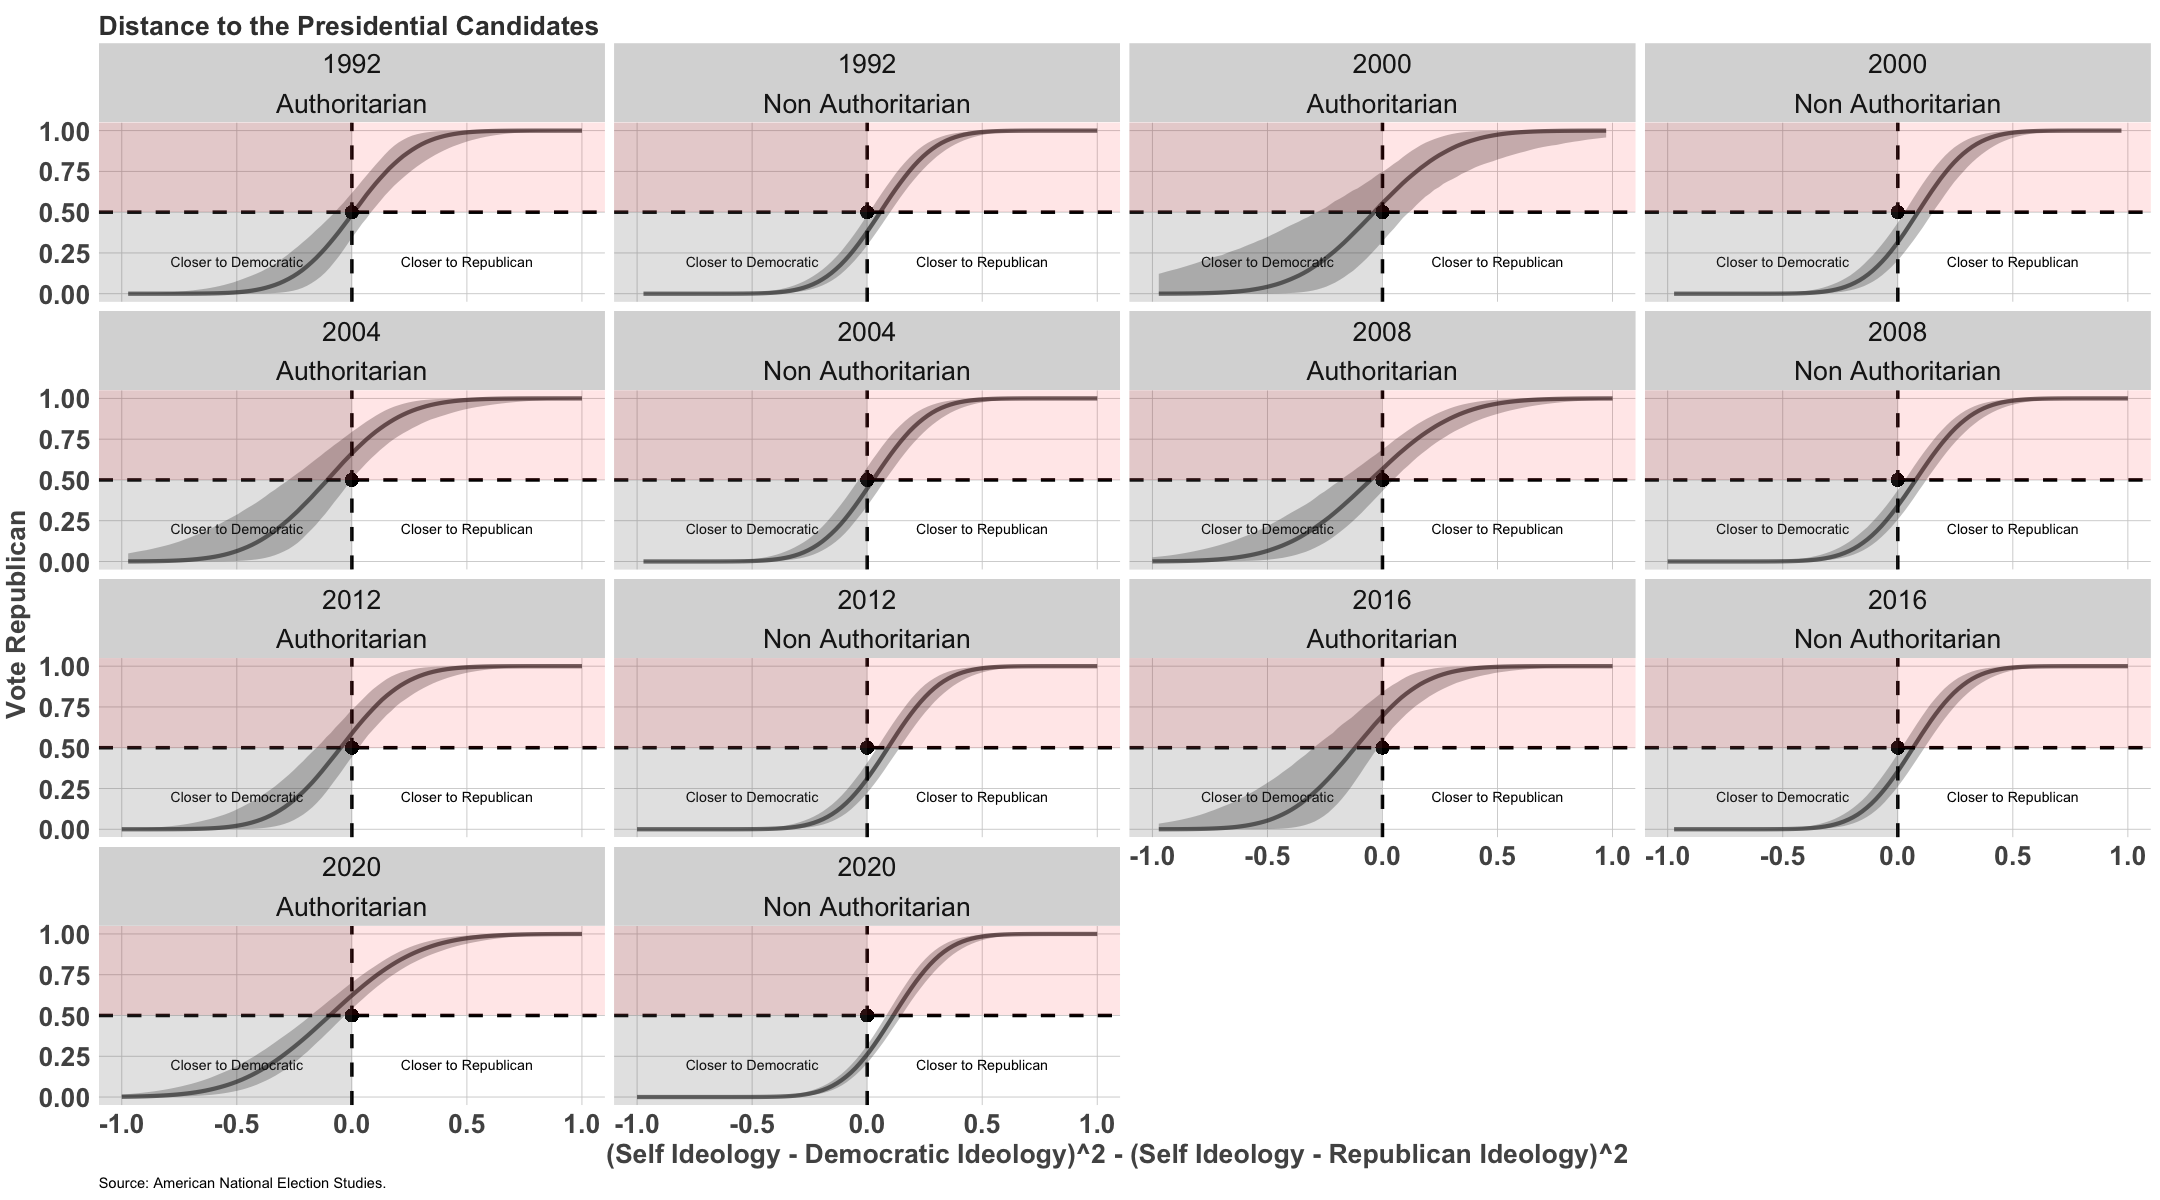

In [54]:
options(repr.plot.width = 18, repr.plot.height = 10)

library(dplyr)
library(brms)
library(modelr)
library(dplyr)
library(modelr)
library(tidybayes)
library(haven)
library(ggplot2)
library(dplyr)
library(cowplot)
library(metR)
load("/Users/Chris/Dropbox/github_repos/Authoritarianism_V2/authoritarianism_replication_docker/Chapter Analysis/Chapter9/spatialModel.rda")
my_list[["data"]] %>% head()

ggtheme <- theme(
  plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 20),
  axis.text.x = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.text.y = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title.y = element_text(size = 16, colour = "#535353", face = "bold", vjust = 1.5),
  axis.ticks = element_blank(),
  strip.text.x = element_text(size = 16),
  panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
  panel.background = element_rect(fill = "white"),
  legend.text = element_text(size = 14),
  legend.title = element_text(size = 16)
)

my_list[["data"]] %>%
  group_by(year) %>%
  data_grid(
    diffOfdiff = seq_range(diffOfdiff, 100),
    authoritarianism = seq_range(authoritarianism, n = 2),
    female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other)
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(my_list[["model"]]) %>%
  mutate(probability = .epred) %>%
  group_by(diffOfdiff, year, authoritarianism) %>%
  summarize(
    mean = quantile(probability, prob = 0.5),
    min = quantile(probability, prob = 0.025),
    max = quantile(probability, prob = 0.975)
  ) %>%
  mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian")) %>%
  ggplot(aes(ymin = min, ymax = max, x = diffOfdiff, y = mean)) +
  facet_wrap(~ year + Authoritarianism, ncol = 4) +
  geom_line(size = 1.2, alpha = 0.60) +
  geom_ribbon(alpha = 0.3) +
  ggtitle("Distance to the Presidential Candidates") +
  ylab("Vote Republican") +
  xlab("Year") +
  ggtheme +
  # Change the y axis limits from 0 to 0.8
  # scale_y_continuous(limits = c(.3, 0.8)) +
  # Add a caption
  labs(caption = "Source: American National Election Studies.") +
  # alignt he caption to the left
  theme(plot.caption = element_text(hjust = 0)) +
  # Make the title smaller, and the second line should be smaller than the first
  theme(plot.title = element_text(size = 16, lineheight = 0.9)) +
  # plot a horizontal line at 0.5
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1) +
  # plot a vertical line at 0
  geom_vline(xintercept = 0, linetype = "dashed", color = "black", size = 1) +
  # add a dot where the line crosses the y intercept
  geom_point(aes(x = 0, y = 0.5), size = 3, color = "black") +
  xlab("(Self Ideology - Democratic Ideology)^2 - (Self Ideology - Republican Ideology)^2  ") +
  # shade everything to the left of the vertical line, light gray
  annotate("rect", xmin = -Inf, xmax = 0, ymin = -Inf, ymax = Inf, alpha = 0.1, fill = "black") +
  # label the shaded area "Closer to Democratic Candidate"
  annotate("text", x = -0.5, y = 0.2, label = "Closer to Democratic", size = 3, color = "black") +
  # shade everything to the left of the vertical line, light gray
  annotate("rect", xmin = -Inf, xmax = 0, ymin = -Inf, ymax = Inf, alpha = 0.1, fill = "grey") +
  # label the shaded area "Closer to Democratic Candidate"
  annotate("text", x = 0.5, y = 0.2, label = "Closer to Republican", size = 3, color = "black") +
  # color everything above 0.5 as light red
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = Inf, alpha = 0.1, fill = "red")


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


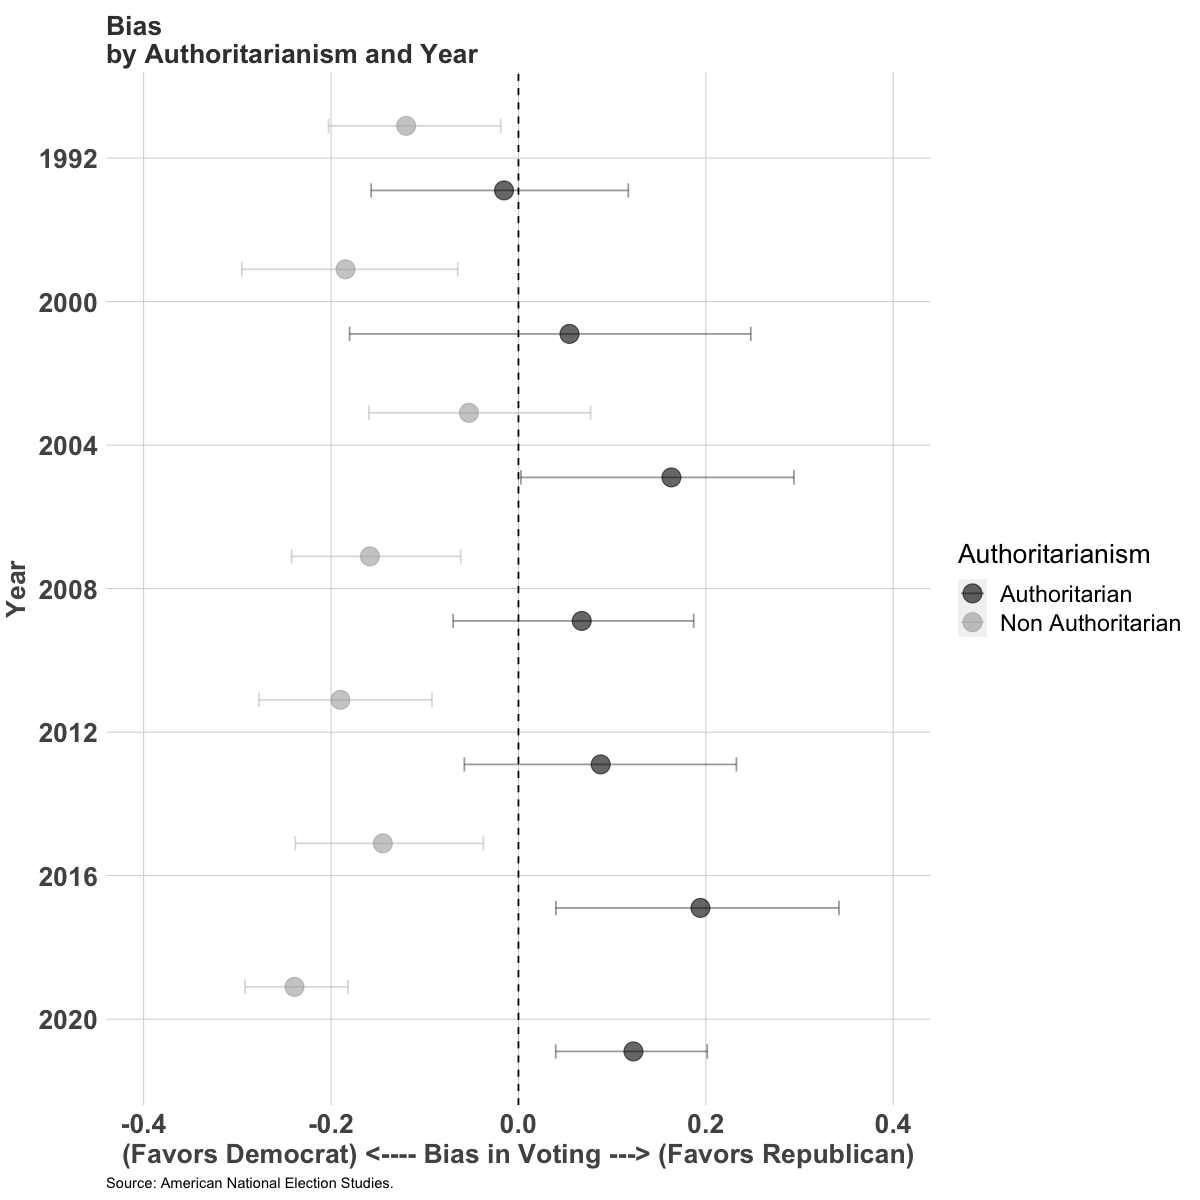

In [85]:
options(repr.plot.width = 10, repr.plot.height = 10)

# Extract the intercepts from the model
my_list[["data"]] %>%
  group_by(year) %>%
  data_grid(
    diffOfdiff = 0,
    authoritarianism = seq_range(authoritarianism, n = 2),
    female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other)
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(my_list[["model"]]) %>%
  mutate(probability = .epred) %>%
  group_by(year, authoritarianism) %>%
  summarize(
    mean = quantile(probability - 0.5, prob = 0.5),
    min = quantile(probability - 0.5, prob = 0.025),
    max = quantile(probability - 0.5, prob = 0.975)
  ) %>%
    mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian")) %>%
    mutate(year = factor(year, levels = rev(c("1992", "2000", "2004", "2008", "2012", "2016", "2020")))) %>%

ggplot(aes(x = as.factor(year), y = mean, ymin = min, ymax = max, color = as.factor(Authoritarianism), group = as.factor(Authoritarianism) )) +
  geom_point(size = 5, alpha = 0.60, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.20, alpha = 0.4, position = position_dodge(width = 0.9)) +
  ggtitle("Bias\nby Authoritarianism and Year") +
  # Add a subtitle
  ylab("Polarization") +
  ggtheme +
  # Change the y axis limits from 0 to 0.8
  scale_y_continuous("(Favors Democrat) <---- Bias in Voting ---> (Favors Republican)", limits = c(-0.4, 0.4)) +
  labs(x = "Year") +
  # Add a caption
  labs(caption = "Source: American National Election Studies.") +
  # alignt he caption to the left
  theme(plot.caption = element_text(hjust = 0)) +
  # Make the title smaller, and the second line should be smaller than the first
  theme(plot.title = element_text(size = 16, lineheight = 0.9))  +
  #reverse the x axis
  coord_flip() +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  # revser the order of year
  #Change the color of label
  scale_color_manual("Authoritarianism", values = c("black", "darkgrey"))   #


## Varying Slopes

Here, I extract the slopes from the model.

\begin{align*}
 b_{low}=  \\
=& b_{auth, year}*(x_{auth, i, year} = 0)* x_{proximity, i, year}  + b_{auth^2, year}*(x_{auth^2, i, year} = 0)* (x_{proximity, i}  + b_{proximity, year} * x_{proximity, i, year} \\
=&  b_{proximity, year} \\
 \end{align*}

\begin{align*}
 b_{high}=  \\
=& b_{auth, year}*(x_{auth, i, year} = 1) * x_{proximity, i, year} + b_{auth^2, year}*(x_{auth^2, i, year} = 1)* x_{proximity, i}  + b_{proximity, year} * x_{proximity, i, year} \\
=&  b_{auth, year} + b_{auth^2, year} + b_{proximity, year}\\
 \end{align*}



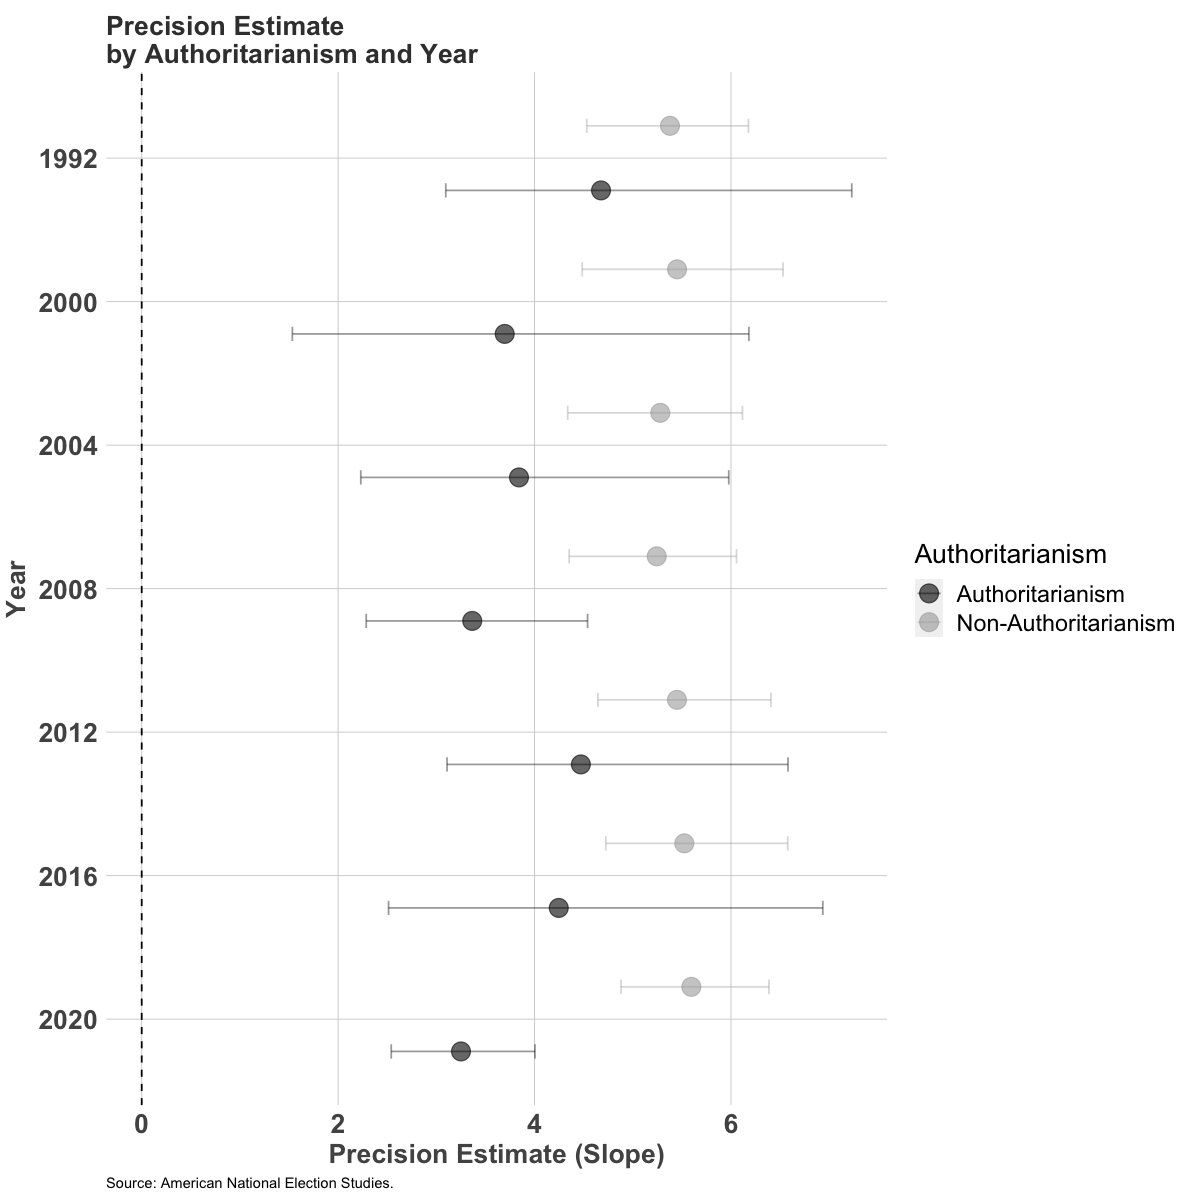

In [106]:
# The value of x when pr =0.5
# Just plug in different values, 0, 1 of authoritarianism to calculate the slope. It's just the fixed and random effects.
pred <- my_list[["model"]] %>%
  spread_draws(b_diffOfdiff, `b_authoritarianism:diffOfdiff`, `b_authoritarianism2:diffOfdiff`, r_year[year, term]) %>%
  filter(term == "diffOfdiff" | term == "authoritarianism:diffOfdiff" | term == "authoritarianism2:diffOfdiff")   %>%
  group_by(.chain, .iteration, .draw, year) %>%
  mutate(re_sum = sum(r_year)) %>%
  filter(term == "diffOfdiff") %>%
  group_by(year) %>%
  summarize(
    a_median = quantile(`b_diffOfdiff` + `b_authoritarianism:diffOfdiff` + `b_authoritarianism2:diffOfdiff` + re_sum, 0.5),
    a_high = quantile(`b_diffOfdiff` + `b_authoritarianism:diffOfdiff` + `b_authoritarianism2:diffOfdiff` + re_sum, 0.975),
    a_low = quantile(`b_diffOfdiff` + `b_authoritarianism:diffOfdiff` + `b_authoritarianism2:diffOfdiff` + re_sum, 0.025),
    na_high = quantile(`b_diffOfdiff` + r_year[term == "diffOfdiff"], 0.975),
    na_low = quantile(`b_diffOfdiff` + r_year[term == "diffOfdiff"], 0.025),
    na_median = median(`b_diffOfdiff` + r_year[term == "diffOfdiff"])
  )

rbind(
pred %>% select(mean = a_median, high = a_high, low = a_low, year) %>% mutate(group = "Authoritarianism"),
pred %>%
  select(mean = na_median, high = na_high, low = na_low, year) %>%
  mutate(group = "Non-Authoritarianism")
) %>%

ggplot(aes(x = as.factor(year), y = mean, ymin = low, ymax = high, color = as.factor(group), group = as.factor(group))) +
  geom_point(size = 5, alpha = 0.60, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.20, alpha = 0.4, position = position_dodge(width = 0.9)) +
  ggtitle("Precision Estimate\nby Authoritarianism and Year") +
  # Add a subtitle
  ylab("Precision Estimate (Slope)") +
  ggtheme +
  # Change the y axis limits from 0 to 0.8
  # scale_y_continuous("Deviation from Spatial Voting", limits = c(-0.4, 0.4)) +
  labs(x = "Year") +
  # Add a caption
  labs(caption = "Source: American National Election Studies.") +
  # alignt he caption to the left
  theme(plot.caption = element_text(hjust = 0)) +
  # Make the title smaller, and the second line should be smaller than the first
  theme(plot.title = element_text(size = 16, lineheight = 0.9)) +
  # reverse the x axis
  coord_flip() +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  # revser the order of year
  # Change the color of label
  scale_color_manual("Authoritarianism", values = c("black", "darkgrey")) +
 scale_x_discrete(limits = rev(levels(as.factor(pred$year))))

# Interpretation

Both authoritarians and non-authoritarians show bias -- a finding that I do think is still consistent with our general findings. There is an asymmetry which emerges for "precision," indicating that ideological proximity is far more diagnostic of voting preferences among non-authoritarians. This is interesting, as it suggests that authoritarians' are less inclined to connect these ideological comparisons to the political candidates.

Another way to view things is to simply ask the question: At what point on the distance continuum are authoritarians and non-authoritarians likely to switch their vote from Democrat to Republican. Ideally that point would be X=0, because when a voter is indifferent, the probability of selecting that candidate is 0.5. However, both groups express a far greater acceptance of ideological distances to their parties. For instance, the first plot above shows that both authoritarians vote Democrat, even when they are ideologically closer to the Democrat. Non-authoritarians vote Democrat even when closer to the Republican. The next question to ask is where on the distance spectrum this occurs -- how much tolerance or slippage does one tolerate before changing vote from Democrat to Republican.

Since the probit model is just 

$$
pr(y = 1) = \Phi(a + b x)
$$

And

$$
\Phi(a + b x) = 0.5\\
\Phi(a + b x = 0) = 0.5\\
\Phi(a + b *(-a/b)) = 0.5
$$

So I plotted -a/b below. I wasn't totally sure how to do things, other than extract the parameters from the model and calculate these values.


In [190]:

predict_term = function(model = my_list[["model"]], group = "Authoritarian"){
intercept = model%>%
  spread_draws(b_Intercept, b_authoritarianism, b_authoritarianism2, r_year[year, term])

 slopes = model %>% spread_draws(b_diffOfdiff, `b_authoritarianism:diffOfdiff`, `b_authoritarianism2:diffOfdiff`, r_year[year, term])


  if(group == "Authoritarian"){
  # The intercepts for authoritarians
     intercept = intercept %>%
       filter(term == "Intercept"| term == "authoritarianism"| term =="authoritarianism2")  %>%
             group_by(.chain, .iteration, .draw, year) %>%
             mutate(re_sum = sum(r_year)) %>%
             filter(term == "Intercept") %>%
             group_by(year) %>%
             mutate(intercept_term = `b_Intercept` + `b_authoritarianism` + `b_authoritarianism2` + re_sum)
    slopes = slopes %>%
            filter(term == "diffOfdiff" | term == "authoritarianism:diffOfdiff" | term == "authoritarianism2:diffOfdiff") %>%
            group_by(.chain, .iteration, .draw, year) %>%
            mutate(re_sum = sum(r_year)) %>%
            filter(term == "diffOfdiff") %>%
            mutate(slope = `b_diffOfdiff` + `b_authoritarianism:diffOfdiff` + `b_authoritarianism2:diffOfdiff` + re_sum)



  }
  else{
   intercept =  intercept %>%
      filter(term == "Intercept")%>%
          group_by(.chain, .iteration, .draw, year) %>%
            mutate(re_sum = sum(r_year)) %>%
            filter(term == "Intercept") %>%
            group_by(year) %>%
            mutate(intercept_term = `b_Intercept` + re_sum)
   slopes = slopes %>%
            filter(term == "diffOfdiff") %>%
            group_by(.chain, .iteration, .draw, year) %>%
            mutate(re_sum = sum(r_year)) %>%
            mutate(slope = `b_diffOfdiff` + re_sum)
             }

  prediction = subset(intercept, select = c(year, intercept_term))
  prediction$slope = slopes$slope
  prediction$point = prediction$intercept_term / prediction$slope * -1
prediction = prediction %>% group_by(year) %>% summarize(mean = mean(point), high = quantile(point, 0.975), low = quantile(point, 0.025))

  return(prediction)
}

predict_term(group = "Non")




year,mean,high,low
<int>,<dbl>,<dbl>,<dbl>
1992,0.034697542,0.08658793,-0.019730540
2000,0.060833360,0.13183435,-0.005596466
2004,0.000257817,0.06162648,-0.067336016
2008,0.057271081,0.11371908,0.002654913
2012,0.064297307,0.12483758,0.006743706
2016,0.044520621,0.10273152,-0.013398939
2020,0.093610004,0.13994062,0.049728799


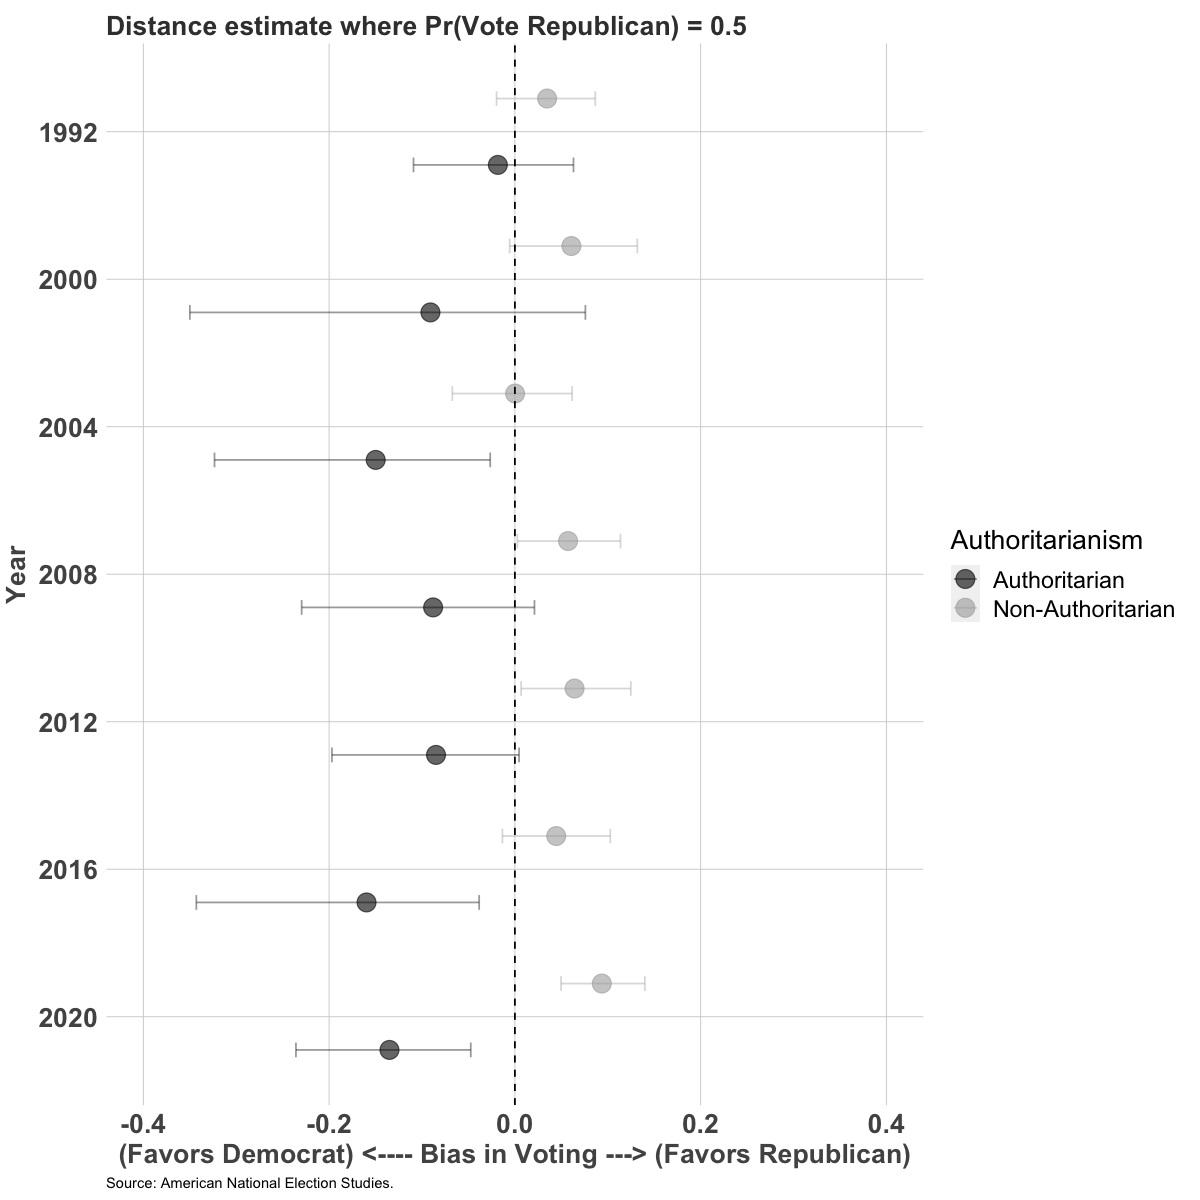

In [188]:
rbind(
  predict_term(group = "Authoritarian") %>% mutate(group = "Authoritarian"),
  predict_term(group = "Non") %>% mutate(group = "Non-Authoritarian")
 ) %>%
 ggplot(aes(x = as.factor(year), y = mean, ymin = low, ymax = high, color = as.factor(group), group = as.factor(group))) +
   geom_point(size = 5, alpha = 0.60, position = position_dodge(width = 0.9)) +
   geom_errorbar(width = 0.20, alpha = 0.4, position = position_dodge(width = 0.9)) +
   ggtitle("Estimated distance where Pr(Vote Republican) = 0.5") +
   # Add a subtitle
   scale_y_continuous("(Favors Democrat) <---- Bias in Voting ---> (Favors Republican)", limits = c(-0.4, 0.4)) +
   ggtheme +
   # Change the y axis limits from 0 to 0.8
   # scale_y_continuous("Deviation from Spatial Voting", limits = c(-0.4, 0.4))
   labs(x = "Year") +
   # Add a caption
   labs(caption = "Source: American National Election Studies.") +
   # alignt he caption to the left
   theme(plot.caption = element_text(hjust = 0)) +
   # Make the title smaller, and the second line should be smaller than the first
   theme(plot.title = element_text(size = 16, lineheight = 0.9)) +
   # reverse the x axis
   coord_flip() +
   geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
   # revser the order of year
   # Change the color of label
   scale_color_manual("Authoritarianism", values = c("black", "darkgrey")) +
   scale_x_discrete(limits = rev(levels(as.factor(pred$year))))

